In [157]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats
from scipy.signal import find_peaks, periodogram
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

In [158]:
TEST_SIZE = 0.50
SEASON = 14
BOXCOX = False
ALPHA = 0.05
DPI = 150

FIG_SIZE = (12, 6)
DOBLE_FIG_SIZE = (12, 12)

TITLE_FONT_SIZE = 15
FONT_SIZE = 12

In [159]:
daily_summary = pd.read_parquet('../clean_data/avg_global.parquet')

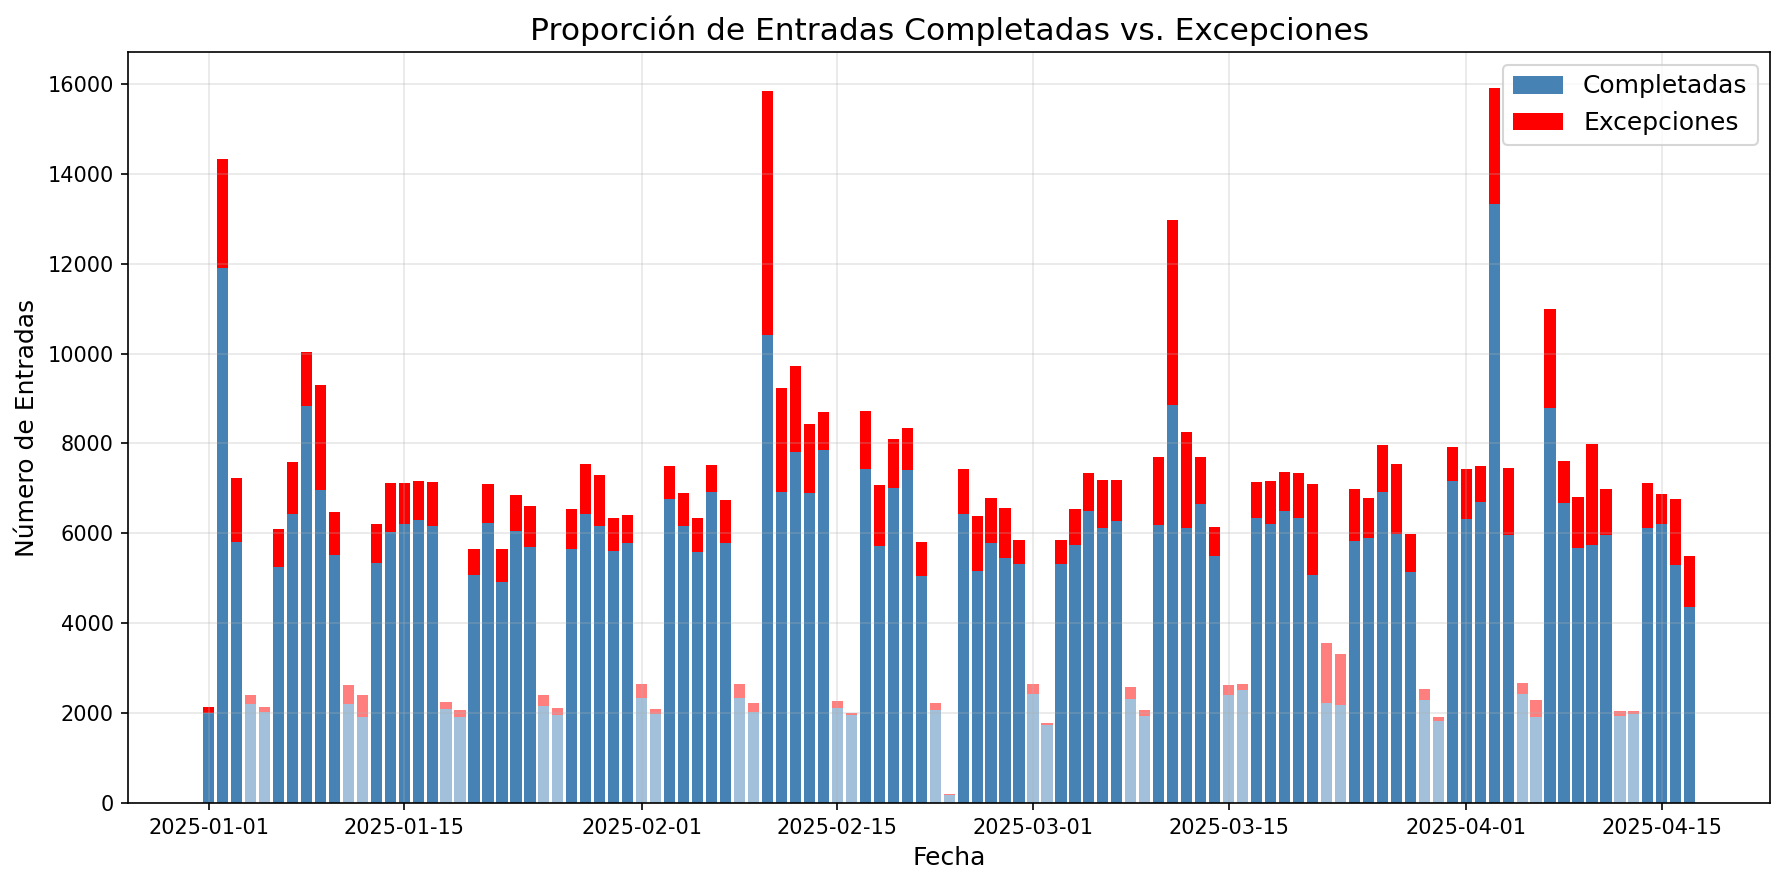

In [161]:
daily_summary['Completed'] = daily_summary['entries'] * (1 - daily_summary['tasa_excepcion'])
daily_summary['Exception'] = daily_summary['entries'] * daily_summary['tasa_excepcion']

is_weekend = daily_summary.index.astype('datetime64[ns]').dayofweek >= 5

fig, ax = plt.subplots(figsize=FIG_SIZE)

# Días de semana
ax.bar(daily_summary.index[~is_weekend], daily_summary['Completed'][~is_weekend], label='Completadas', color='steelblue')
ax.bar(daily_summary.index[~is_weekend], daily_summary['Exception'][~is_weekend], bottom=daily_summary['Completed'][~is_weekend], label='Excepciones', color='red')

# Fines de semana
ax.bar(daily_summary.index[is_weekend], daily_summary['Completed'][is_weekend], color='steelblue', alpha=0.5)
ax.bar(daily_summary.index[is_weekend], daily_summary['Exception'][is_weekend], bottom=daily_summary['Completed'][is_weekend], color='red', alpha=0.5)

ax.set_title('Proporción de Entradas Completadas vs. Excepciones', fontsize=TITLE_FONT_SIZE)
ax.set_xlabel('Fecha', fontsize=FONT_SIZE)
ax.set_ylabel('Número de Entradas', fontsize=FONT_SIZE)
ax.legend(fontsize=FONT_SIZE)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../images/proporcion_entradas_completadas_vs_excepciones.png', dpi=DPI)
plt.show()


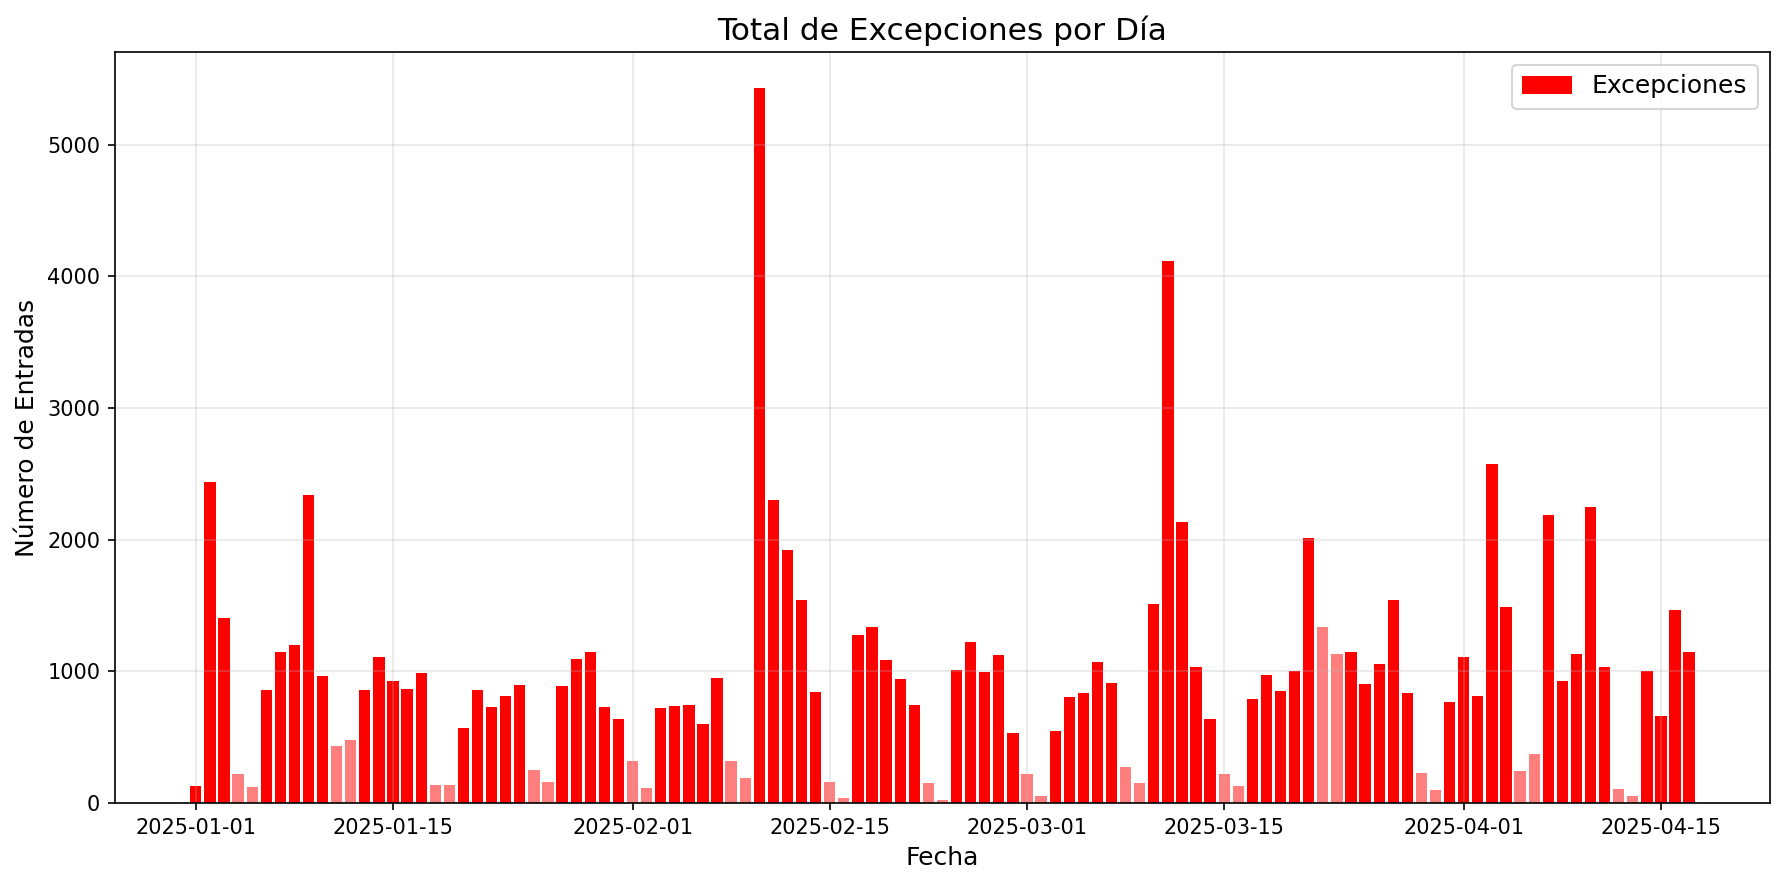

In [162]:
fig, ax = plt.subplots(figsize=FIG_SIZE)

# Días de semana
ax.bar(daily_summary.index[~is_weekend], daily_summary['Exception'][~is_weekend], label='Excepciones', color='red')

# Fines de semana
ax.bar(daily_summary.index[is_weekend], daily_summary['Exception'][is_weekend], color='red', alpha=0.5)

ax.set_title('Total de Excepciones por Día', fontsize=TITLE_FONT_SIZE)
ax.set_xlabel('Fecha', fontsize=FONT_SIZE)
ax.set_ylabel('Número de Entradas', fontsize=FONT_SIZE)
ax.legend(fontsize=FONT_SIZE)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../images/total_excepciones_por_dia.png', dpi=DPI)
plt.show()

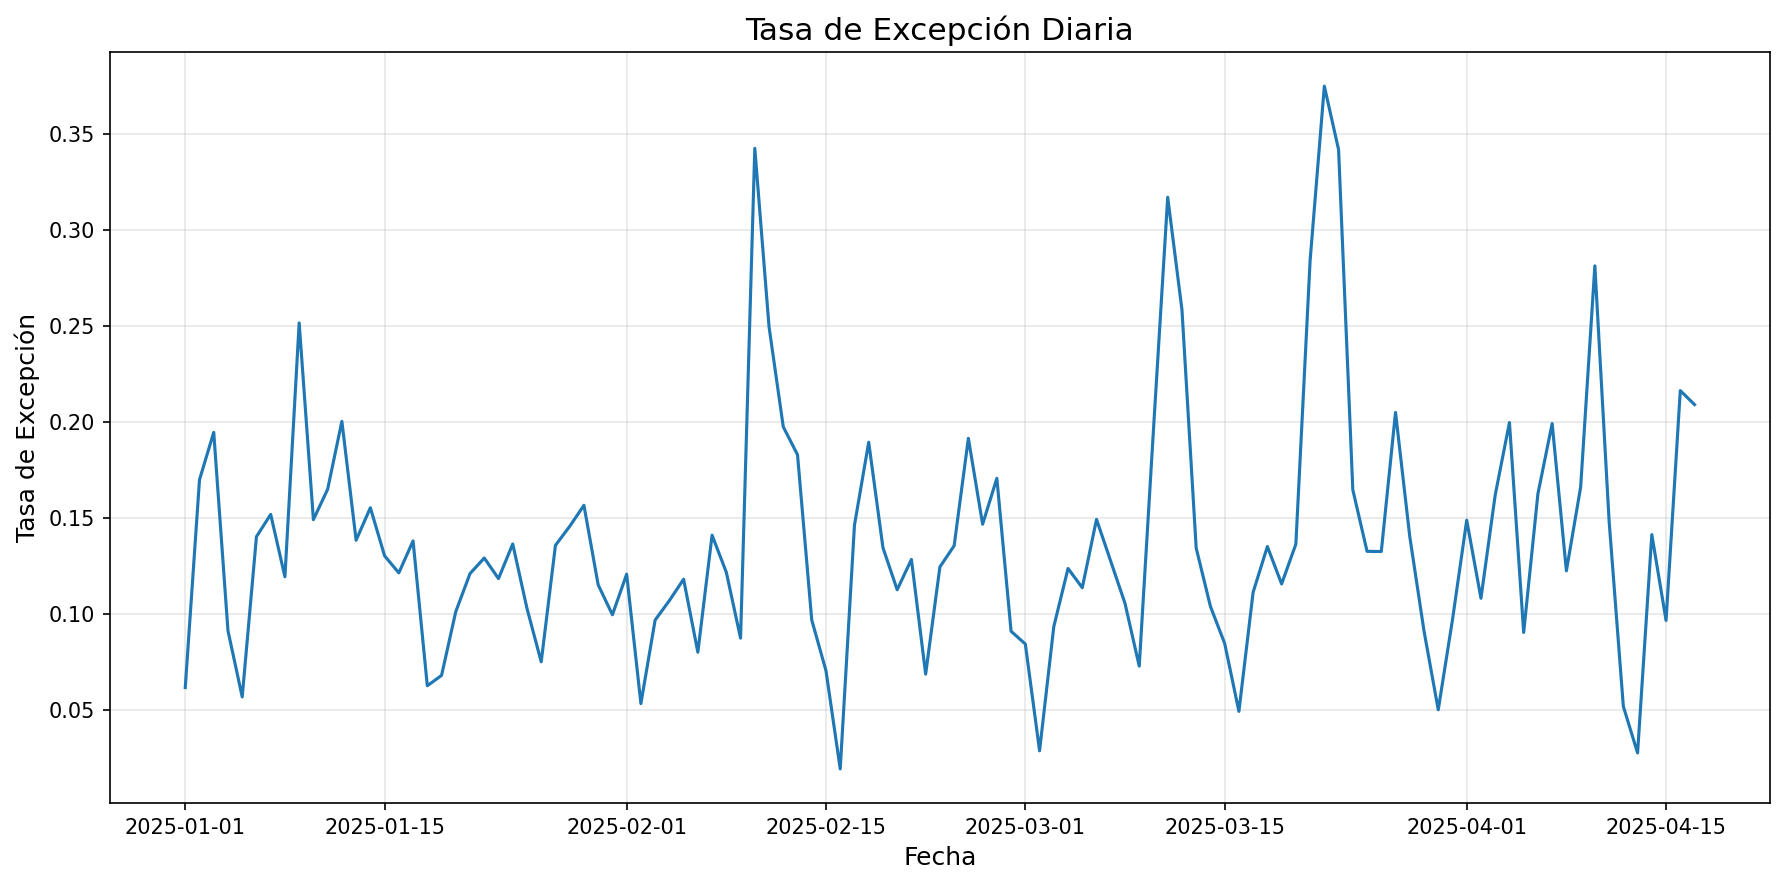

In [163]:
transformed_data, best_lambda = stats.boxcox(daily_summary['tasa_excepcion'])
daily_summary['tasa_excepcion_boxcox'] = transformed_data

fig, ax = plt.subplots(figsize=FIG_SIZE)
daily_summary['tasa_excepcion'].plot(ax=ax)
ax.set_title('Tasa de Excepción Diaria', fontsize=TITLE_FONT_SIZE)
ax.set_xlabel('Fecha', fontsize=FONT_SIZE)
ax.set_ylabel('Tasa de Excepción', fontsize=FONT_SIZE)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../images/tasa_excepcion_tiempo.png', dpi=DPI)

plt.show()

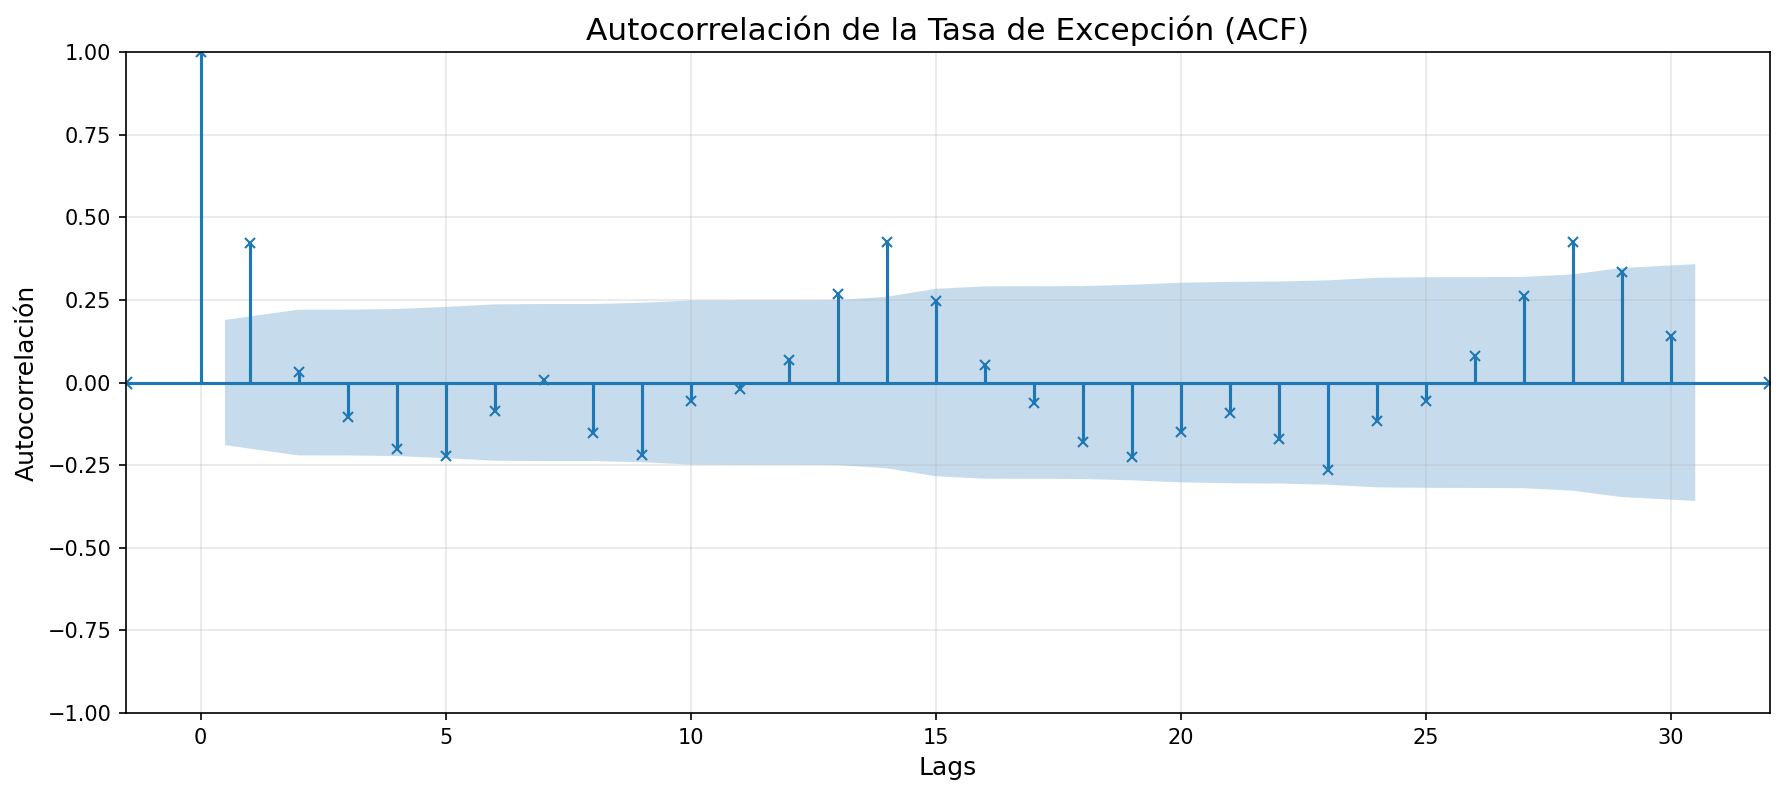

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=FIG_SIZE)

plot_acf(
    daily_summary['tasa_excepcion_boxcox'].dropna(),
    ax=axes,
    lags=30,
    alpha=ALPHA,
    adjusted=True,
)
axes.grid(True, alpha=0.3)

axes.set_title('Autocorrelación de la Tasa de Excepción (ACF)', fontsize=TITLE_FONT_SIZE)
axes.set_xlabel('Lags', fontsize=FONT_SIZE)
axes.set_ylabel('Autocorrelación', fontsize=FONT_SIZE)

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.savefig('../images/acf_tasa_excepcion.png', dpi=DPI)
plt.show()

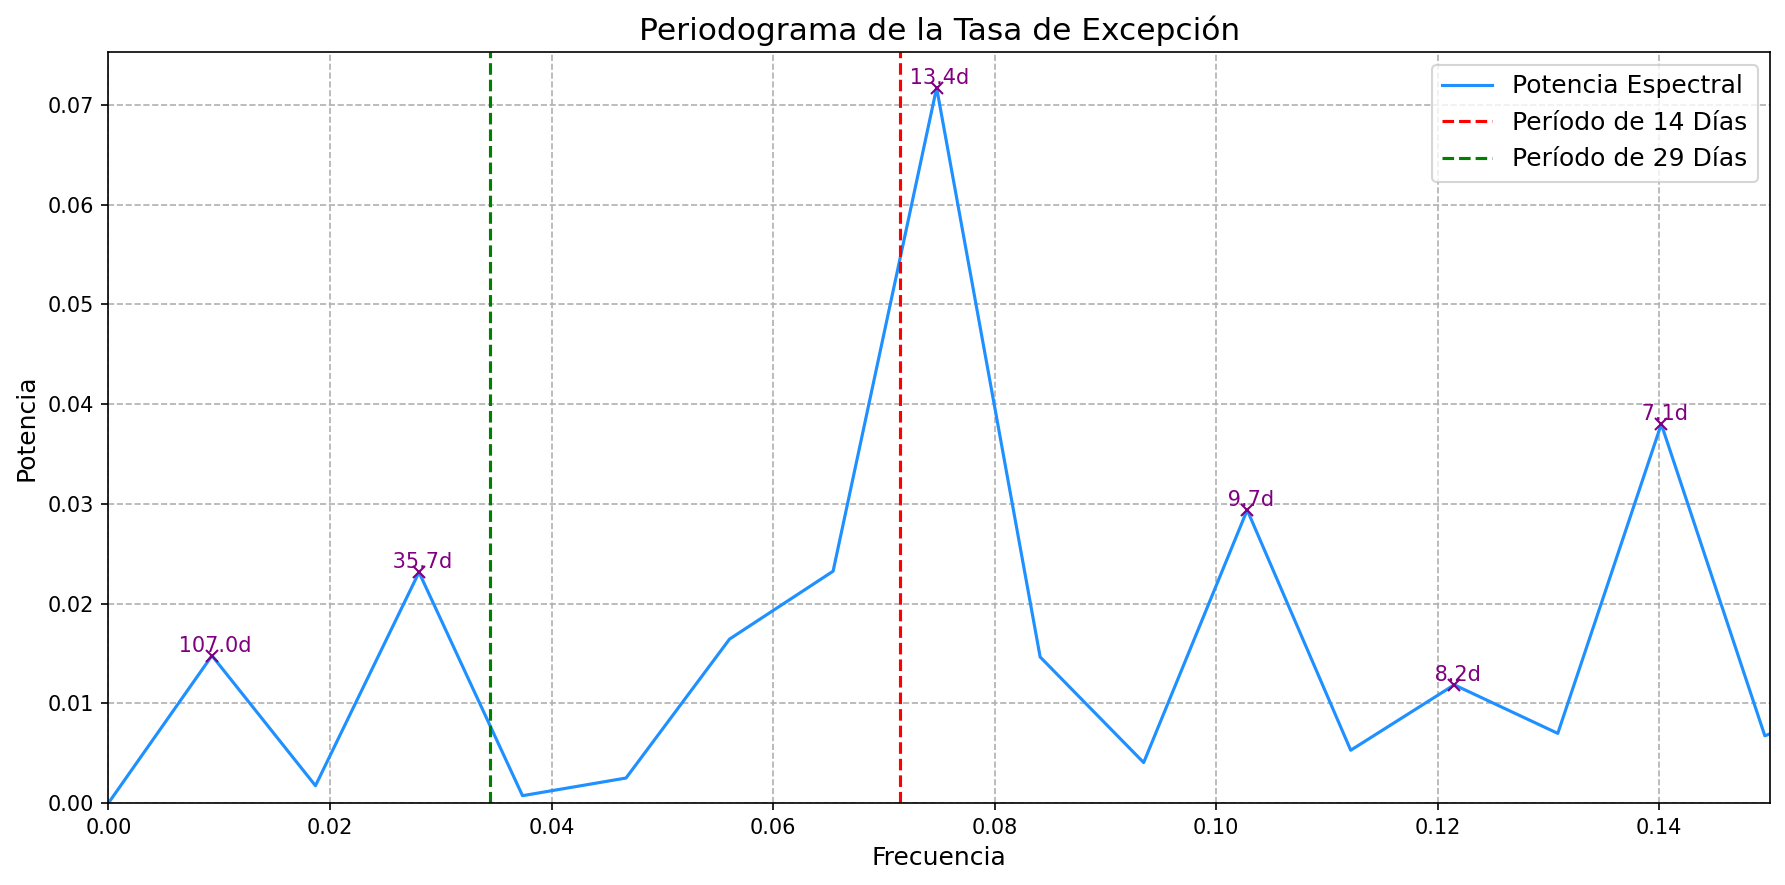

In [ ]:
time_series = daily_summary['tasa_excepcion'].dropna()
frequencies, power = periodogram(time_series, fs=1)

fig, ax = plt.subplots(figsize=FIG_SIZE)

height_threshold = np.mean(power)
peak_indices, _ = find_peaks(power, height=height_threshold)

ax.plot(frequencies, power, color='dodgerblue', label='Potencia Espectral')

labeled_periods = set()

for i in peak_indices:
    freq = frequencies[i]
    if freq > 0.15 or freq == 0:
        continue

    period = 1 / freq
    rounded_period = round(period,1)
    
    if rounded_period not in labeled_periods:
        pwr = power[i]
        ax.plot(freq, pwr, "x", color="purple")
        ax.text(freq, pwr, f" {rounded_period}d", verticalalignment='bottom', ha='center', color='purple')
        labeled_periods.add(rounded_period)


ax.axvline(x=1/14, color='red', linestyle='--', linewidth=1.5, label='Período de 14 Días')
ax.axvline(x=1/29, color='green', linestyle='--', linewidth=1.5, label='Período de 29 Días')

ax.set_title('Periodograma de la Tasa de Excepción', fontsize=TITLE_FONT_SIZE)
ax.set_xlabel('Frecuencia', fontsize=FONT_SIZE)
ax.set_ylabel('Potencia', fontsize=FONT_SIZE)
ax.legend(fontsize=FONT_SIZE)
ax.grid(True, linestyle='--')
ax.set_xlim(0, 0.15)
ax.set_ylim(0)

plt.tight_layout()
plt.savefig('../images/periodograma_tasa_excepcion.png', dpi=DPI)
plt.show()


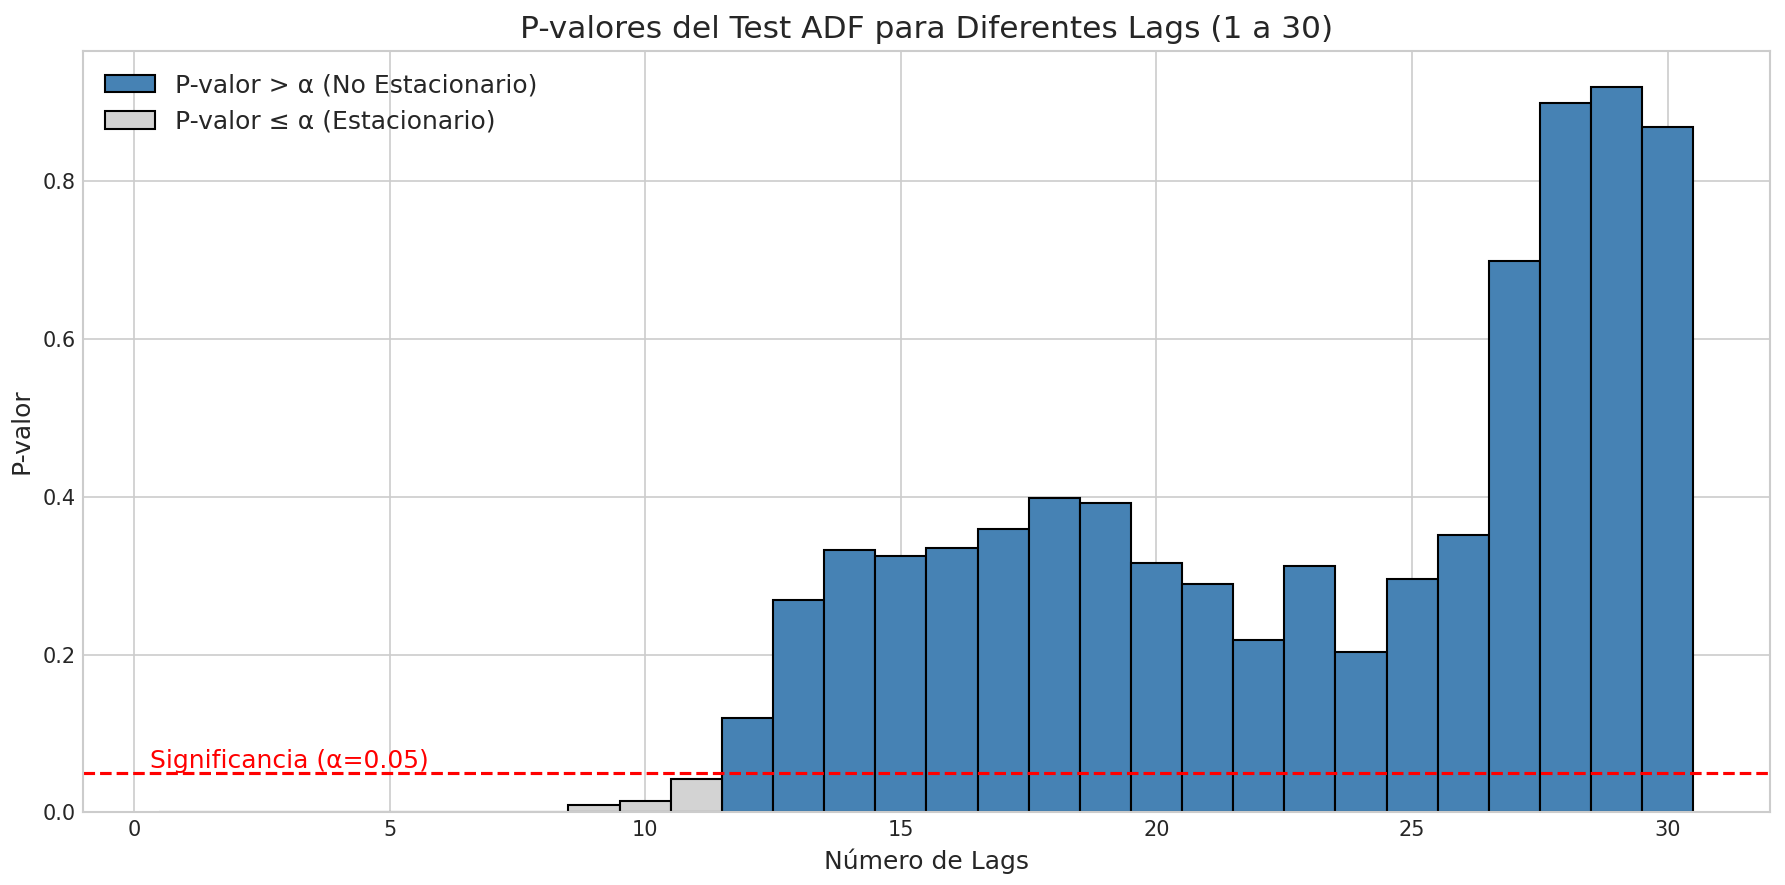

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')

serie_adf = daily_summary['tasa_excepcion'].dropna()
max_lags_adf = 30

p_values = []
lags_range = range(1, max_lags_adf + 1)

for i in lags_range:
    adf_result = adfuller(serie_adf, maxlag=i, autolag=None)
    p_values.append(adf_result[1])

adf_pvals_df = pd.DataFrame({'Lag': list(lags_range), 'P-Value': p_values})

fig, ax = plt.subplots(figsize=FIG_SIZE)

# Destacar los valores no estacionarios
above_alpha = adf_pvals_df[adf_pvals_df['P-Value'] > ALPHA]
below_alpha = adf_pvals_df[adf_pvals_df['P-Value'] <= ALPHA]

ax.bar(above_alpha['Lag'], above_alpha['P-Value'], width=1.0, color='steelblue', label='P-valor > α (No Estacionario)', edgecolor='black', linewidth=1)
ax.bar(below_alpha['Lag'], below_alpha['P-Value'], width=1.0, color='lightgray', label='P-valor ≤ α (Estacionario)', edgecolor='black', linewidth=1)

ax.axhline(y=ALPHA, color='red', linestyle='--')
ax.text(0, ALPHA, f'  Significancia (α={ALPHA})', ha='left', va='bottom', color='red', fontsize=FONT_SIZE)

ax.set_title(f'P-valores del Test ADF para Diferentes Lags (1 a {max_lags_adf})', fontsize=TITLE_FONT_SIZE)
ax.set_xlabel('Número de Lags', fontsize=FONT_SIZE)
ax.set_ylabel('P-valor', fontsize=FONT_SIZE)
ax.legend(fontsize=FONT_SIZE)

plt.tight_layout()
plt.style.use('default')
plt.rcParams['figure.dpi'] = DPI
plt.savefig('../images/adf_test_tasa_excepcion.png', dpi=DPI)
plt.show()

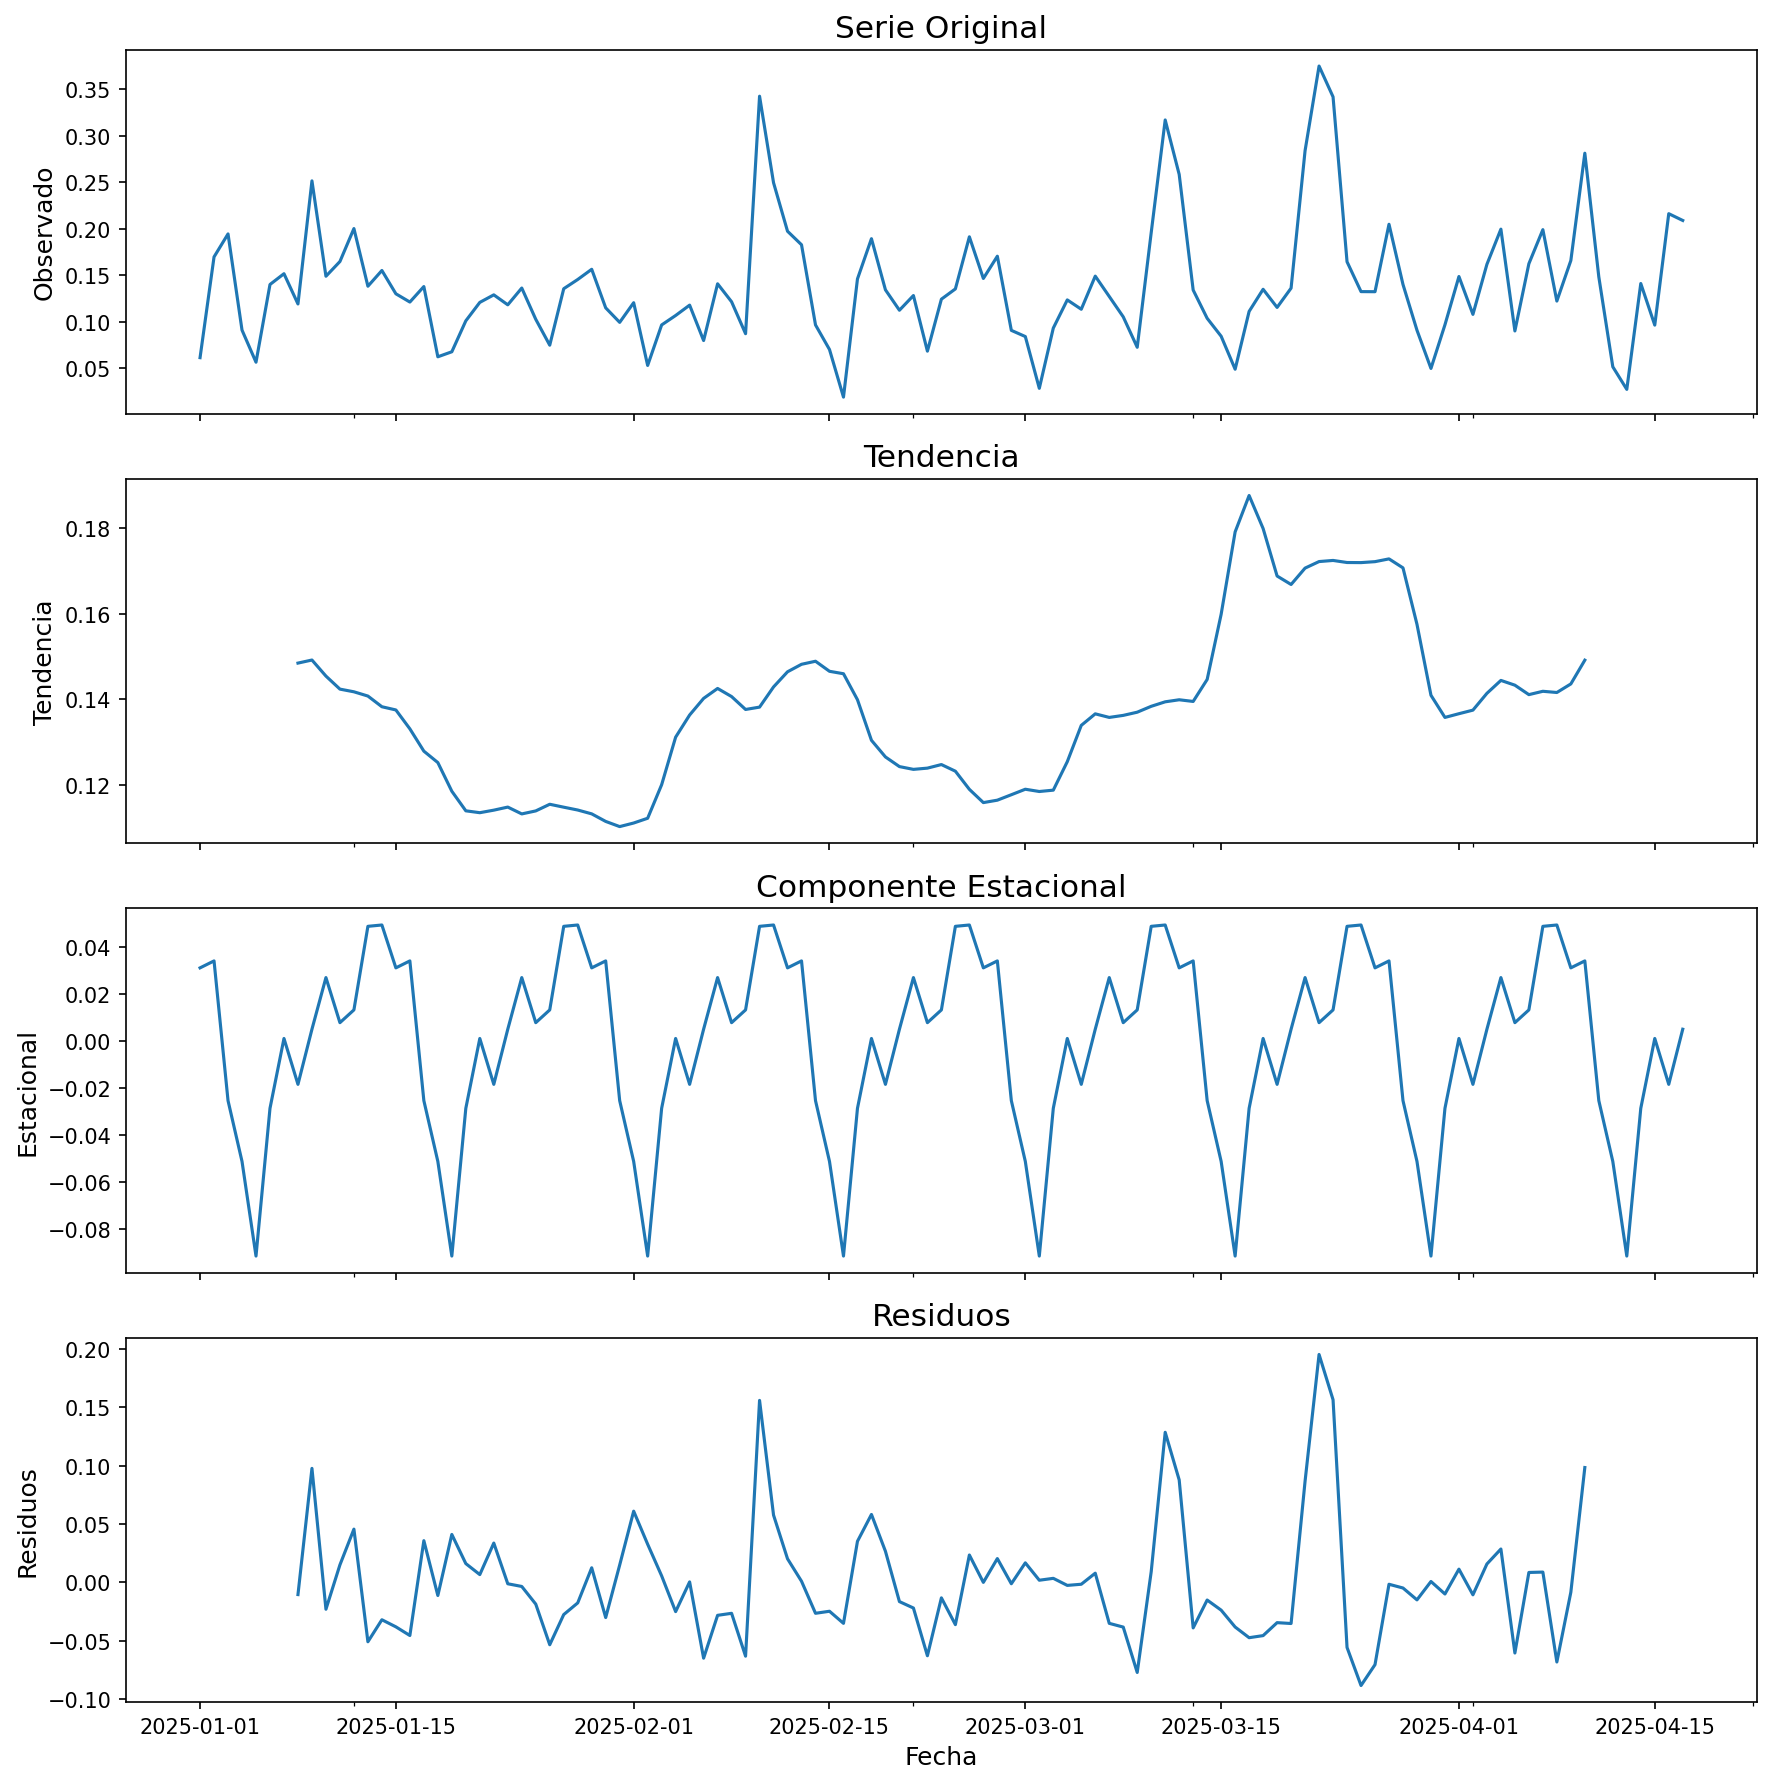

In [ ]:
decomposition = seasonal_decompose(
    daily_summary['tasa_excepcion'],
    model='add',
    period=SEASON,
)

fig, axes = plt.subplots(4, 1, figsize=DOBLE_FIG_SIZE, sharex=True)
# fig.suptitle(f'Descomposición Estacional de tasa_excepcion {SEASON} días', fontsize=TITLE_FONT_SIZE)

decomposition.observed.plot(ax=axes[0], title='Serie Original')
axes[0].set_title('Serie Original', fontsize=TITLE_FONT_SIZE)
axes[0].set_ylabel('Observado', fontsize=FONT_SIZE)

decomposition.trend.plot(ax=axes[1], title='Tendencia')
axes[1].set_title('Tendencia', fontsize=TITLE_FONT_SIZE)
axes[1].set_ylabel('Tendencia', fontsize=FONT_SIZE)

decomposition.seasonal.plot(ax=axes[2], title='Componente Estacional')
axes[2].set_title('Componente Estacional', fontsize=TITLE_FONT_SIZE)
axes[2].set_ylabel('Estacional', fontsize=FONT_SIZE)

decomposition.resid.plot(ax=axes[3], title='Residuos')
axes[3].set_title('Residuos', fontsize=TITLE_FONT_SIZE)
axes[3].set_ylabel('Residuos', fontsize=FONT_SIZE)

axes[3].set_xlabel('Fecha', fontsize=FONT_SIZE)

plt.tight_layout()
plt.savefig('../images/descomposicion_tasa_excepcion.png', dpi=DPI)
plt.show()

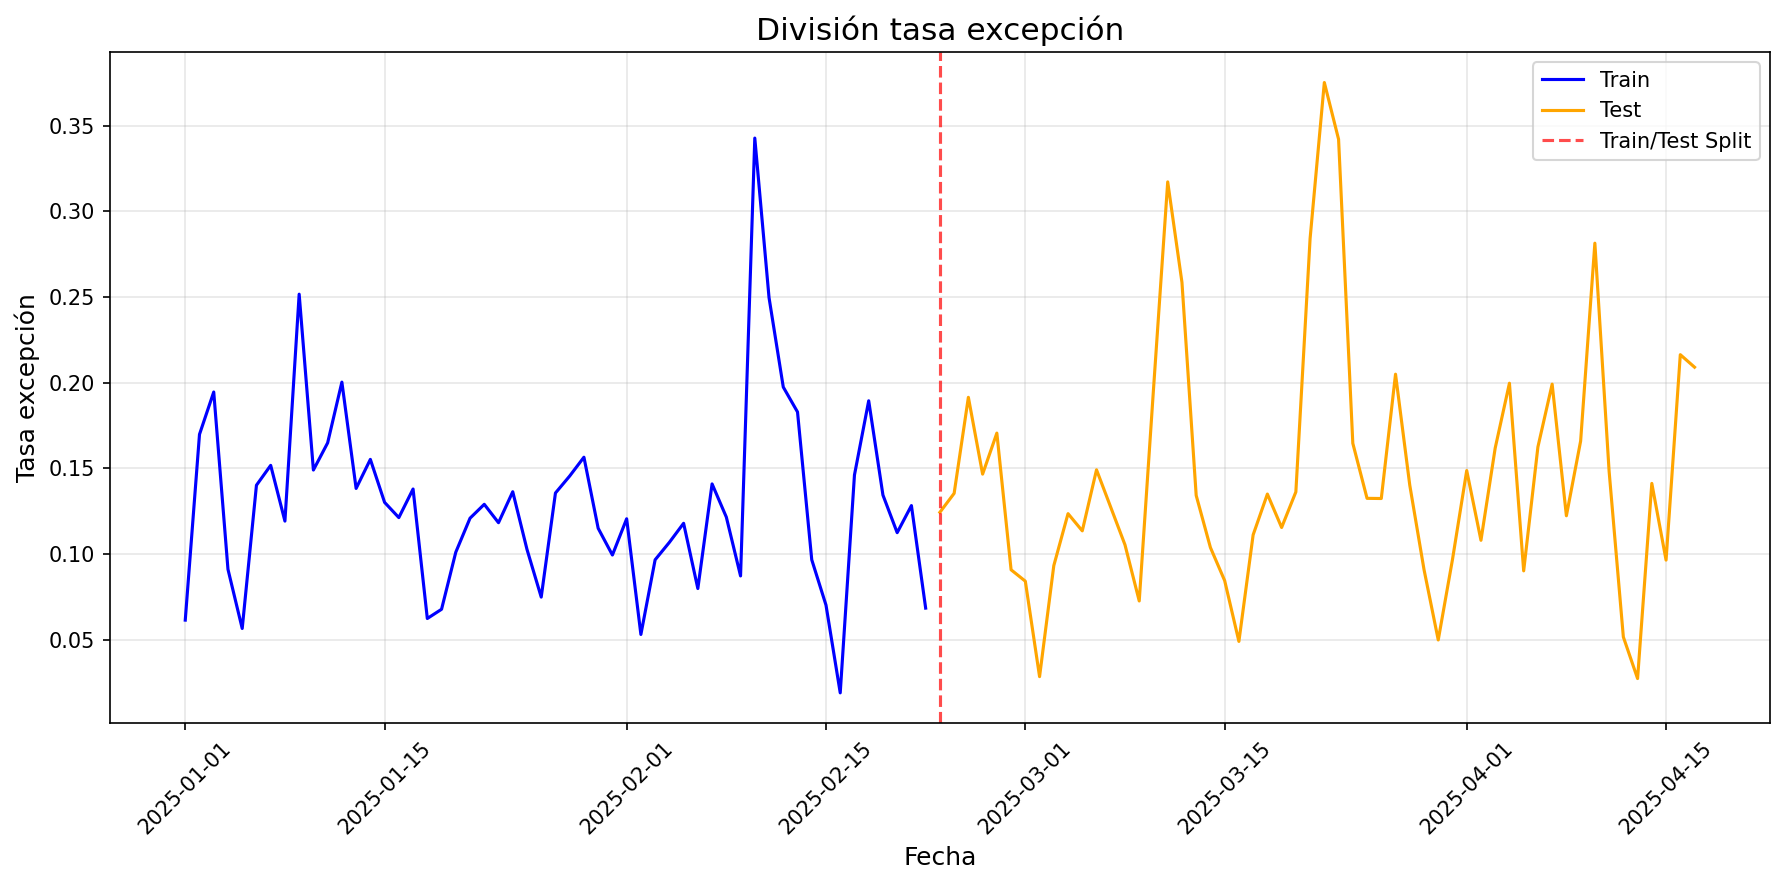

In [ ]:
train, test = train_test_split(
    daily_summary['tasa_excepcion'],
    test_size=TEST_SIZE,
    shuffle=False
)

plt.figure(figsize=FIG_SIZE)
plt.plot(train.index, train.values, label='Train', color='blue')
plt.plot(test.index, test.values, label='Test', color='orange')
plt.axvline(
    x=test.index[0],
    color='red',
    linestyle='--',
    alpha=0.7,
    label='Train/Test Split'
)
plt.xlabel('Fecha', fontsize=FONT_SIZE)
plt.ylabel('Tasa excepción', fontsize=FONT_SIZE)
plt.title('División tasa excepción', fontsize=TITLE_FONT_SIZE)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../images/division_tasa_excepcion.png', dpi=DPI)
plt.show()

In [ ]:
model_auto = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='add',
    seasonal_periods=SEASON,
    initialization_method='estimated',
    use_boxcox=BOXCOX,
).fit()

print("Modelo ETS Automático:")
print(f"AIC: {model_auto.aic:.2f}")
print(f"BIC: {model_auto.bic:.2f}")
print(f"Alpha (nivel): {model_auto.params['smoothing_level']:.4f}")
print(f"Beta (tendencia): {model_auto.params['smoothing_trend']:.4f}")
print(f"Gamma (estacional): {model_auto.params['smoothing_seasonal']:.4f}")

forecast_steps = len(test)
forecast = model_auto.forecast(steps=forecast_steps)
forecast_index = test.index

forecast_train = model_auto.fittedvalues

Modelo ETS Automático:
AIC: -298.88
BIC: -263.42
Alpha (nivel): 0.0000
Beta (tendencia): 0.0000
Gamma (estacional): 0.0000


c:\Users\santi\Documents\Codigo\proyecto de grado\Prediccion_de_fallas\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


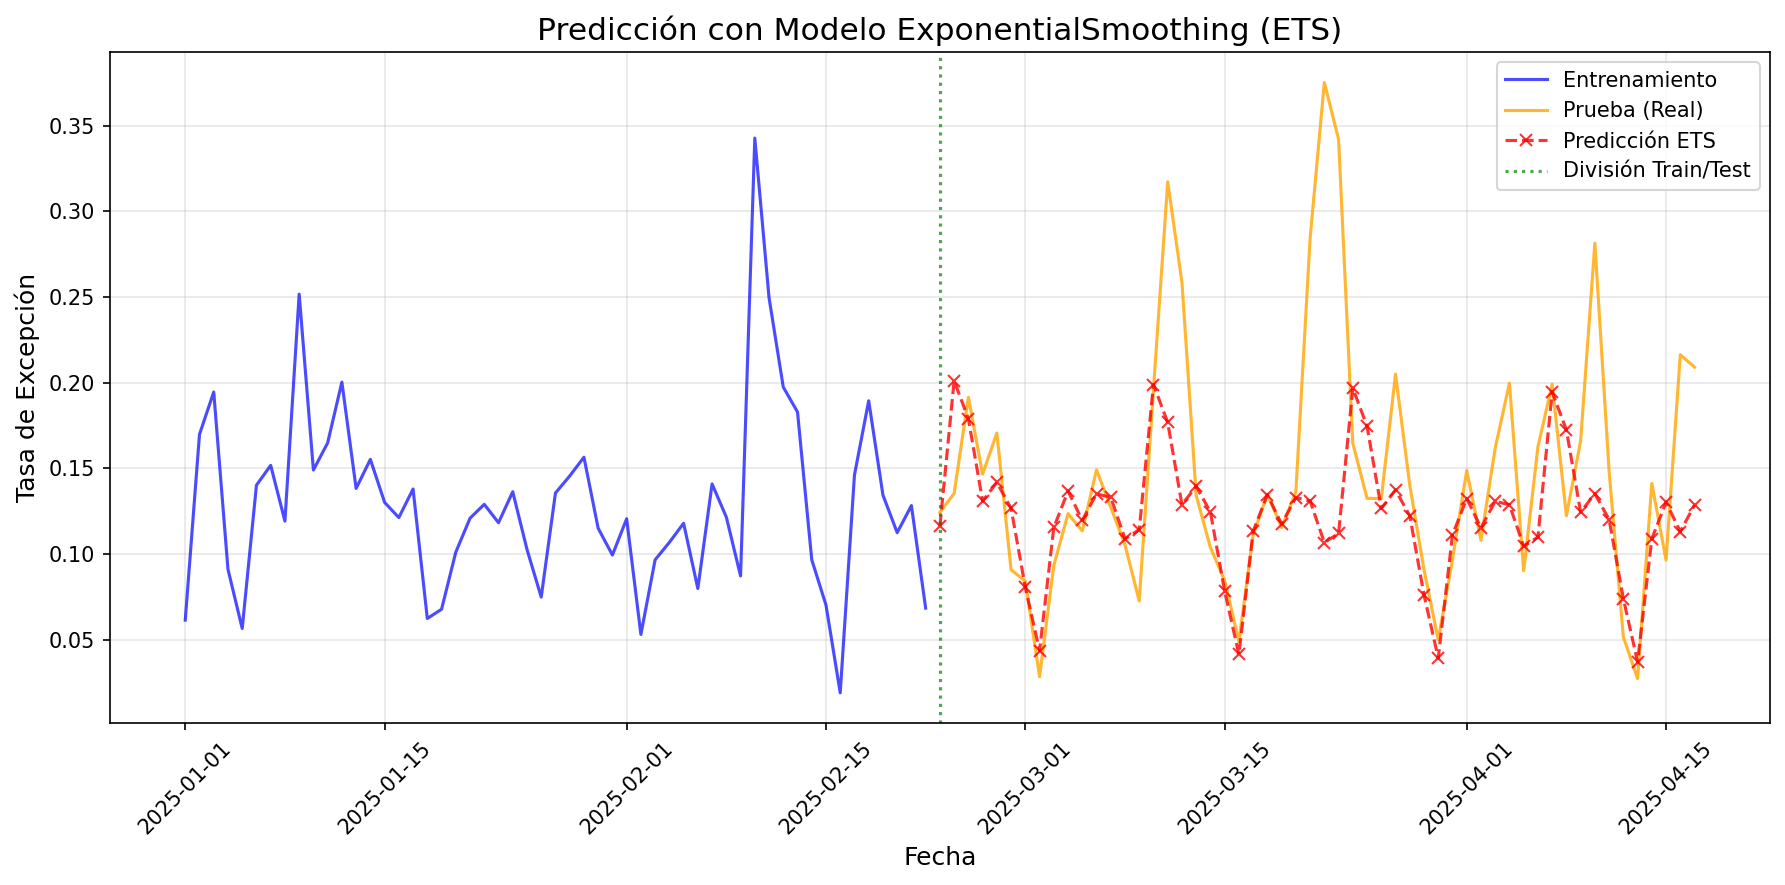

In [ ]:
train_orig, test_orig = train_test_split(
    daily_summary['tasa_excepcion'], test_size=TEST_SIZE, shuffle=False
)

plt.figure(figsize=FIG_SIZE)

plt.plot(train.index, train.values, label='Entrenamiento', color='blue', alpha=0.7)
plt.plot(test.index, test.values, label='Prueba (Real)', color='orange', alpha=0.8)
plt.plot(forecast_index, forecast, label='Predicción ETS', color='red', alpha=0.8, linestyle='--', marker='x')

plt.axvline(
    x=test.index[0],
    color='green',
    linestyle=':',
    alpha=0.7,
    label='División Train/Test'
)

plt.xlabel('Fecha', fontsize=FONT_SIZE)
plt.ylabel('Tasa de Excepción', fontsize=FONT_SIZE)
plt.title('Predicción con Modelo ExponentialSmoothing (ETS)', fontsize=TITLE_FONT_SIZE)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../images/prediccion_ets_tasa_excepcion.png', dpi=DPI)
plt.show()

In [ ]:
train_orig, test_orig = train_test_split(
    daily_summary['tasa_excepcion'], test_size=TEST_SIZE, shuffle=False
)

mae_train = mean_absolute_error(train, forecast_train)
mse_train = mean_squared_error(train, forecast_train)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(train, forecast_train)
mase_train = mean_absolute_scaled_error(train, forecast_train, y_train=train)

mae_test = mean_absolute_error(test, forecast)
mse_test = mean_squared_error(test, forecast)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(test, forecast)
mase_test = mean_absolute_scaled_error(test, forecast, y_train=train)

# Baseline: Predicción con la media de entrenamiento
mean_prediction = train.mean()
mean_forecast_train = pd.Series(mean_prediction, index=train.index)
mean_forecast_test = pd.Series(mean_prediction, index=test.index)

# Métricas para el baseline en conjunto de test
mae_mean_test = mean_absolute_error(test, mean_forecast_test)
mse_mean_test = mean_squared_error(test, mean_forecast_test)
rmse_mean_test = np.sqrt(mse_mean_test)
r2_mean_test = r2_score(test, mean_forecast_test)
mase_mean_test = mean_absolute_scaled_error(test, mean_forecast_test, y_train=train)

metricas_df = pd.DataFrame({
    'Train': [mae_train, mse_train, rmse_train, r2_train, mase_train],
    'Test': [mae_test, mse_test, rmse_test, r2_test, mase_test],
    'Media': [
        mean_absolute_error(test, mean_forecast_test),
        mean_squared_error(test, mean_forecast_test),
        np.sqrt(mean_squared_error(test, mean_forecast_test)),
        r2_score(test, mean_forecast_test),
        mean_absolute_scaled_error(test, mean_forecast_test, y_train=train)
    ]
}, index=['MAE', 'MSE', 'RMSE', 'R²', 'MASE'])

train_diff = np.diff(train)
forecast_train_diff = np.diff(forecast_train)
min_len_train = min(len(train_diff), len(forecast_train_diff))
train_diff_aligned = train_diff[:min_len_train]
forecast_train_diff_aligned = forecast_train_diff[:min_len_train]
da_train = np.mean( (np.sign(train_diff_aligned) == np.sign(forecast_train_diff_aligned)).astype(int) ) * 100

test_diff = np.diff(test)
forecast_diff = np.diff(forecast)
min_len_test = min(len(test_diff), len(forecast_diff))
test_diff_aligned = test_diff[:min_len_test]
forecast_diff_aligned = forecast_diff[:min_len_test]
da_test = np.mean( (np.sign(test_diff_aligned) == np.sign(forecast_diff_aligned)).astype(int) ) * 100

# DA para el modelo de media (predicción constante, diff es cero)
mean_forecast_test_diff = np.diff(mean_forecast_test)
min_len_mean_test = min(len(test_diff), len(mean_forecast_test_diff))
da_mean_test = np.mean(
    (np.sign(test_diff[:min_len_mean_test]) == np.sign(mean_forecast_test_diff[:min_len_mean_test])).astype(int)
) * 100

metricas_df.loc['DA (%)'] = [da_train, da_test, da_mean_test]

metricas_df.round(4)

residuals = test - forecast
metricas_df

,Train,Test,Media
MAE,0.031945,0.040993,0.052627
MSE,0.001803,0.004798,0.005694
RMSE,0.042457,0.069265,0.075461
R²,0.401831,0.108989,-0.057536
MASE,0.693919,0.890475,1.143195
DA (%),57.692308,75.471698,0.000000
